In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential

In [2]:
# path to the files
train_dir = pathlib.Path('training_2 classes')
test_dir = pathlib.Path('testing_2 classes')

In [3]:
# to check if images are there
import os

train_dir = 'training_2 classes'
test_dir = 'testing_2 classes'

# List files in train directory
train_files = os.listdir(train_dir)
print(f"Files in training directory: {train_files}")

# List files in test directory
test_files = os.listdir(test_dir)
print(f"Files in testing directory: {test_files}")

Files in training directory: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'NORMAL', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Files in testing directory: ['Acne and Rosacea Phot

In [4]:
# Load the data
batch_size = 32
img_height = 180
img_width = 180


In [5]:
# splitting the dataset
train_ds_orig = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_orig = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 15633 files belonging to 24 classes.
Using 12507 files for training.
Found 15633 files belonging to 24 classes.
Using 3126 files for validation.
Found 4081 files belonging to 24 classes.


In [6]:
class_names = train_ds_orig.class_names
num_classes = len(class_names)

In [7]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_orig.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_orig.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Data Augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
         layers.RandomContrast(0.2),  # Add contrast augmentation(added)
        layers.RandomBrightness(0.2),  # Add brightness augmentation(added)

    ]
)

c:\Users\vedik\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Create the model
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),  # Feature Extraction Layer
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,000 (136.72 KB)

 Trainable params: 35,000 (136.72 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 95s 201ms/step - accuracy: 0.0892 - loss: 3.0242 - val_accuracy: 0.1270 - val_loss: 2.9334
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 214ms/step - accuracy: 0.1235 - loss: 2.9226 - val_accuracy: 0.1190 - val_loss: 2.9143
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 212ms/step - accuracy: 0.1334 - loss: 2.8968 - val_accuracy: 0.1408 - val_loss: 2.8817
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.1424 - loss: 2.8808 - val_accuracy: 0.1446 - val_loss: 2.8739
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 207ms/step - accuracy: 0.1498 - loss: 2.8613 - val_accuracy: 0.1638 - val_loss: 2.8233
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 213ms/step - accuracy: 0.1647 - loss: 2.8202 - val_accuracy: 0.1587 - val_loss: 2.8410
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 234ms/step - accuracy: 0.1599 - loss: 2.8120 - val_accuracy: 0.1711 - val_loss: 2.7877
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 71s 181ms/step - accuracy: 0.1633 - loss: 2

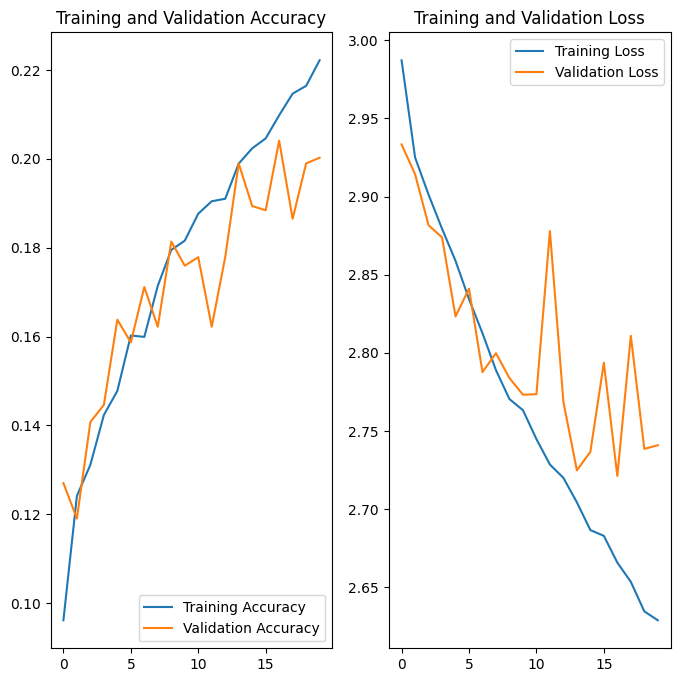

In [13]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [15]:
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import os

# Set your model and class_names here
# Example:
# model = ...
# class_names = [...]

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, img_height=224, img_width=224):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Function to predict the class of an image
def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    return predicted_class, confidence

# Ask the user for the path to the test image
test_img_path = input("Please enter the path to your image: ").strip()

# Predict the class of the test image
predicted_class, confidence = predict_image(model, test_img_path)
print(f"This image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
This image most likely belongs to Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions with a 29.24% confidence.


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os